In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import json
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
import re
import colorsys
from scipy.ndimage import zoom

In [ ]:
data = [
    ["orange", "hood", 10],
    ["dark green", "front door", 20],
    ["yellow", "rear door", 30],
    ["cyan", "frame", 40],
    ["purple", "rear quarter panel", 50],
    ["light green", "trunk lid", 60],
    ["blue", "fender", 70],
    ["pink", "bumper", 80],
    ["no color", "rest of car", 90],
    ["white", "background", 0]
]

color_to_hue = {
    "orange": 30,
    "dark green": 120,
    "yellow": 60,
    "cyan": 180,
    "purple": 270,
    "light green": 150,
    "blue": 210,
    "pink": 330,
    #TODO: change this to black later
    "no color": 0,
    "white": 1,
}

#, row[1] this can be put into the thing too
class_decode_dict = {row[2]: color_to_hue.get(row[0], row[0]) for row in data}
class_decode_dict

{10: 30,
 20: 120,
 30: 60,
 40: 180,
 50: 270,
 60: 150,
 70: 210,
 80: 330,
 90: 0,
 0: 1}

In [ ]:
def filter_files_by_regex(directory, pattern):
    # Use os.listdir() to get a list of all files and directories in the specified directory
    file_list = os.listdir(directory)

    # Use a list comprehension to filter the files based on the regex pattern
    filtered_files = [filename for filename in file_list if re.match(pattern, filename)]

    return filtered_files

In [ ]:
def load_numpy_arrays(directory, file_names,hue_mapping=class_decode_dict, max_load = 0):
    # Create an empty list to store the numpy arrays
    x = []
    y = []

    # Iterate through the file names
    for filename in file_names: #and len(x) < max_load:

        # Load the numpy array from the file path
        array = np.load(directory + filename)
        # Extract the first 3 channels for x
        x.append(array[..., :3])


        # Extract y
        hue_values = np.vectorize(hue_mapping.get)(array[..., -1])

        # Convert hue values to RGB values
        y_temp = np.empty_like(array[..., :3], dtype=np.uint8)
        for i in range(256):
            for j in range(256):
                if hue_values[i, j] == 1:
                    y_temp[i, j] = (0,0,0)

                elif hue_values[i, j] == 0:
                    y_temp[i, j] = (array[i, j, 0], array[i, j, 1], array[i, j, 2])

                else:
                    hsv_color = (hue_values[i, j] / 360.0, 1, 1)  # Convert hue to HSV format
                    rgb_color = colorsys.hsv_to_rgb(*hsv_color)  # Convert to RGB
                    y_temp[i, j] = (int(rgb_color[0] * 255), int(rgb_color[1] * 255), int(rgb_color[2] * 255))

        y.append(y_temp)




    return x,y

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
directory_path = 'drive/My Drive/carseg_data/arrays/'
# regex_pattern = r'black_5_doors_[0-9]*\.npy'
regex_pattern = r'orange_3_doors_[0-9]*\.npy'
black_car_image_file_names = sorted(filter_files_by_regex(directory_path, regex_pattern))
# Limit to the first ten elements
# black_car_image_file_names = black_car_image_file_names[:3]


for filename in black_car_image_file_names:
    print(filename)

Mounted at /content/drive
orange_3_doors_0001.npy
orange_3_doors_0002.npy
orange_3_doors_0003.npy
orange_3_doors_0004.npy
orange_3_doors_0005.npy
orange_3_doors_0006.npy
orange_3_doors_0007.npy
orange_3_doors_0008.npy
orange_3_doors_0009.npy
orange_3_doors_0010.npy
orange_3_doors_0011.npy
orange_3_doors_0012.npy
orange_3_doors_0013.npy
orange_3_doors_0014.npy
orange_3_doors_0015.npy
orange_3_doors_0016.npy
orange_3_doors_0017.npy
orange_3_doors_0018.npy
orange_3_doors_0019.npy
orange_3_doors_0020.npy
orange_3_doors_0021.npy
orange_3_doors_0022.npy
orange_3_doors_0023.npy
orange_3_doors_0024.npy
orange_3_doors_0025.npy
orange_3_doors_0026.npy
orange_3_doors_0027.npy
orange_3_doors_0028.npy
orange_3_doors_0029.npy
orange_3_doors_0030.npy
orange_3_doors_0031.npy
orange_3_doors_0032.npy
orange_3_doors_0033.npy
orange_3_doors_0034.npy
orange_3_doors_0035.npy
orange_3_doors_0036.npy
orange_3_doors_0037.npy
orange_3_doors_0038.npy
orange_3_doors_0039.npy
orange_3_doors_0040.npy
orange_3_doors

In [ ]:
numpy_arraysx, numpy_arraysy = load_numpy_arrays(directory_path, black_car_image_file_names, max_load=2001)

In [ ]:
len(numpy_arraysx)

2001

In [ ]:
def show_image(image):
    # Extract the image data from the last channel (the alpha channel, for example)
    image_data = image[:, :]

    # Display the image using Matplotlib
    plt.imshow(image_data)  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Turn off the axis labels and ticks
    plt.show()

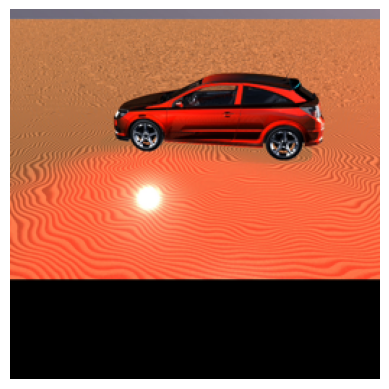

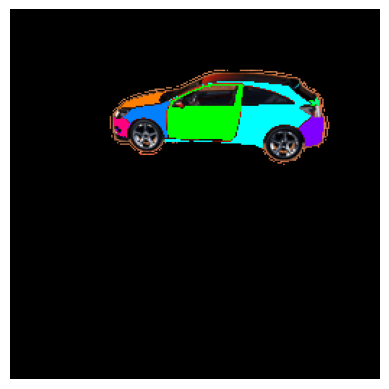

In [ ]:
show_image(numpy_arraysx[0])
show_image(numpy_arraysy[0])

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, concatenate, Dropout,\
                                    Lambda, Conv2DTranspose, Add
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import tensorflow as tf
import os

num_classes=10
imshape = (256, 256, 3)
n_classes = 3
#n_classes = len(data)


def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x


def dice(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def unet(pretrained=False, base=4):

    if pretrained:
        path = os.path.join('models', model_name+'.model')
        if os.path.exists(path):
            model = load_model(path, custom_objects={'dice': dice})
            model.summary()
            return model
        else:
            print('Failed to load existing model at: {}'.format(path))

    if n_classes == 1:
        loss = 'binary_crossentropy'
        final_act = 'sigmoid'
    elif n_classes > 1:
        loss = 'categorical_crossentropy'
        final_act = 'softmax'

    b = base
    i = Input((imshape[0], imshape[1], imshape[2]))
    s = Lambda(lambda x: preprocess_input(x)) (i)

    c1 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(2**(b+4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(2**(b+4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = BatchNormalization()(c5)

    u6 = Conv2DTranspose(2**(b+3), (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(2**(b+2), (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(2**(b+1), (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(2**b, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    #o = Conv2D(n_classes, (1, 1), activation=final_act) (c9)
    o = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    o = BatchNormalization()(o)
    model = Model(inputs=i, outputs=o, name="asd")#model_name)
    #optimizer = Adam(learning_rate=1e-4, clipvalue=0.5)  # Experiment with different clip values
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
    model.compile(optimizer=Adam(1e-6), loss=loss, metrics=[dice])#, callbacks=[reduce_lr])
    model.summary()

    return model

In [ ]:
import numpy as np
import pickle
import os
from PIL import Image

import imgaug as ia
from imgaug import augmenters as iaa
import cv2
import json
import tensorflow as tf


ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Multiply((1.2, 1.5)),
    iaa.Affine(
        #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        rotate=(-90, 90)
    ),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 8))
    )
], random_order=True)


class DataGenerator(tf.keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, file_paths, batch_size):
        self.file_paths = file_paths
        self.batch_size = batch_size


    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.ceil(len(self.file_paths) / self.batch_size))


    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size

        batch_files = self.file_paths[start_index:end_index]
        batch_images, batch_masks = self.load_batch(batch_files)

        return batch_images, batch_masks

    def load_batch(self, batch_files):
      batch_images = []
      batch_masks = []

      for file_path in batch_files:
          #print("Loading file:", file_path)
          data = np.load(file_path)


          image = data[:, :, :3]  # Extracting the RGB channels
          mask = data[:, :, 3]    # Extracting the class values

          mask = np.clip(mask, 0, num_classes - 1)

          mask_one_hot = tf.keras.utils.to_categorical(mask, num_classes=num_classes)


          batch_images.append(image)
          batch_masks.append(mask_one_hot)

      return np.array(batch_images), np.array(batch_masks)

In [ ]:
file_list = os.listdir('drive/My Drive/carseg_data/arrays/')
print("Files in the directory:", file_list)

Files in the directory: ['orange_3_doors_1170.npy', 'orange_3_doors_1171.npy', 'orange_3_doors_1172.npy', 'orange_3_doors_1173.npy', 'orange_3_doors_1174.npy', 'orange_3_doors_1175.npy', 'orange_3_doors_1176.npy', 'orange_3_doors_1177.npy', 'orange_3_doors_1178.npy', 'orange_3_doors_1179.npy', 'orange_3_doors_1180.npy', 'orange_3_doors_1181.npy', 'orange_3_doors_1182.npy', 'orange_3_doors_1183.npy', 'orange_3_doors_1184.npy', 'orange_3_doors_1185.npy', 'orange_3_doors_1186.npy', 'orange_3_doors_1187.npy', 'orange_3_doors_1188.npy', 'orange_3_doors_1189.npy', 'orange_3_doors_1190.npy', 'orange_3_doors_1191.npy', 'orange_3_doors_1192.npy', 'orange_3_doors_1193.npy', 'orange_3_doors_1194.npy', 'orange_3_doors_1195.npy', 'orange_3_doors_1196.npy', 'orange_3_doors_1197.npy', 'orange_3_doors_1198.npy', 'orange_3_doors_1199.npy', 'orange_3_doors_1200.npy', 'orange_3_doors_1201.npy', 'orange_3_doors_1202.npy', 'orange_3_doors_1203.npy', 'orange_3_doors_1204.npy', 'orange_3_doors_1205.npy', 'or

In [ ]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#TODO: Make tensorflow work
#TODO: make the data generator work,
# Keras no longer in tensorflow? checkout how that works
# from tensorboard_callbacks import TrainValTensorBoard, TensorBoardMask
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

# Specify the directory path
directory_path = 'drive/My Drive/carseg_data/arrays/'

# Create your U-Net model
model = unet(pretrained=False, base=4)
# ... (define your U-Net architecture)

# Create an instance of the data generator with absolute file paths
file_names = os.listdir(directory_path)
file_paths = [os.path.join(directory_path, filename) for filename in file_names]
batch_size = 32
train_generator = DataGenerator(file_paths, batch_size)

# Compile and fit the model using the data generator
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(generator=train_generator, epochs=500)

Model: "asd"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['lambda[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                 

<ipython-input-13-ca8ce2a30723>:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator, epochs=500)


Epoch 1/500
18/94 [====>.........................] - ETA: 35:00 - loss: 2.7808 - accuracy: 0.0588

KeyboardInterrupt: ignored